In [ ]:
from google.colab import drive
import os

drive.mount('/content/gdrive')
os.chdir('gdrive/Shared drives/CIS680Group/hw4')

!pip install pytorch_lightning

Mounted at /content/gdrive
     |████████████████████████████████| 1.0 MB 4.3 MB/s 
     |████████████████████████████████| 829 kB 27.7 MB/s 
     |████████████████████████████████| 329 kB 42.9 MB/s 
     |████████████████████████████████| 596 kB 64.4 MB/s 
     |████████████████████████████████| 125 kB 75.1 MB/s 
     |████████████████████████████████| 1.1 MB 55.2 MB/s 
     |████████████████████████████████| 160 kB 70.3 MB/s 
     |████████████████████████████████| 192 kB 75.8 MB/s 
     |████████████████████████████████| 271 kB 58.8 MB/s 
  Created wheel for future: filename=future-0.18.2-py3-none-any.whl size=491070 sha256=08385f8892e477e8651fe555d784266a8a61f0d474adaa4047ea29a52d707946
  Stored in directory: /root/.cache/pip/wheels/56/b0/fe/4410d17b32f1f0c3cf54cdfb2bc04d7b4b8f4ae377e2229ba0
Successfully built future
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
  Attempting unins

In [ ]:
import numpy as np
import h5py

with h5py.File('Dataset/hw3_mycocodata_img_comp_zlib.h5', 'r') as f:
  images = f['data'][()]

with h5py.File('Dataset/hw3_mycocodata_mask_comp_zlib.h5', 'r') as f:
  masks = f['data'][()]

labels = np.load('Dataset/hw3_mycocodata_labels_comp_zlib.npy', allow_pickle=True)
bounding_boxes = np.load('Dataset/hw3_mycocodata_bboxes_comp_zlib.npy', allow_pickle=True)

In [ ]:
import pytorch_lightning as pl
import torch
from torch import nn
import torchvision

# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
seed = 17
torch.manual_seed(seed);

In [ ]:
len_labels = [len(lab) for lab in labels]
cumsum = np.cumsum(len_labels)

mask_list = []
for i in range(len(len_labels)):
  start_idx = 0 if i == 0 else cumsum[i-1]
  mask_list.append(masks[start_idx:cumsum[i]])

masks = np.array(mask_list, dtype=object)
del mask_list

In [ ]:
import torch
from torchvision import transforms
import torch.nn.functional as F
from torch.utils.data import DataLoader
import h5py
import numpy as np
from utils import *
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from dataset import *

# images:         (batch_size, 3, 800, 1088)
# labels:         list with len: batch_size, each (n_obj,)
# masks:          list with len: batch_size, each (n_obj, 800,1088)
# bounding_boxes: list with len: batch_size, each (n_obj, 4)
def collate_fn(batch):
    images, labels, masks, bounding_boxes, indices = list(zip(*batch))
    return torch.stack(images), labels, masks, bounding_boxes, indices

train_dataset = COCODataset(images[:2540], labels[:2540], masks[:2540], bounding_boxes[:2540])
val_dataset = COCODataset(images[2540:], labels[2540:], masks[2540:], bounding_boxes[2540:])
train_loader = DataLoader(train_dataset, batch_size=4, collate_fn=collate_fn, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, collate_fn=collate_fn, shuffle=False)

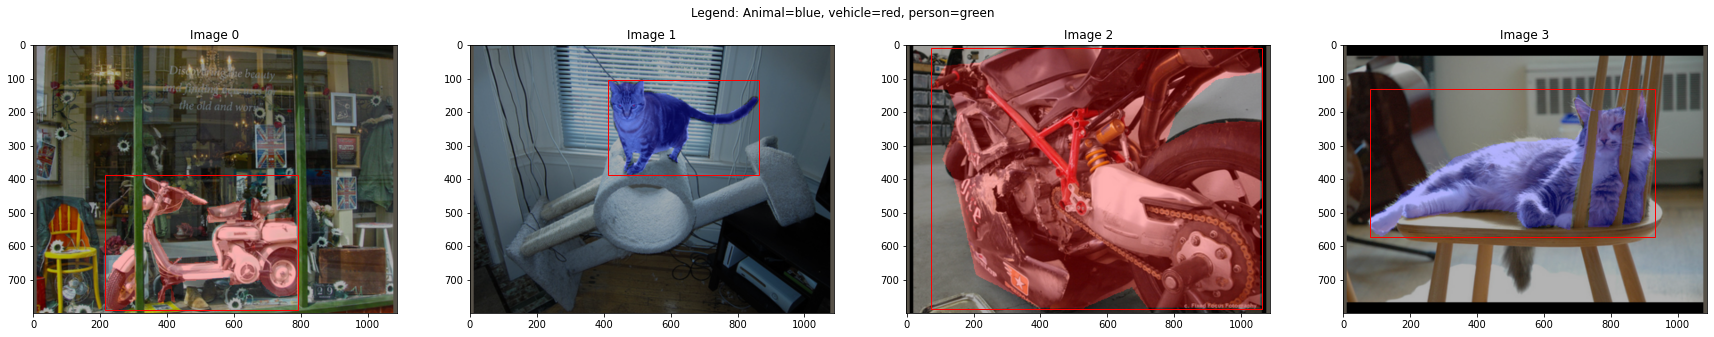

In [ ]:
# DATASET PREPROCESSING VISUALIZATION CELL
import logging
from matplotlib.patches import Rectangle

logger = logging.getLogger()
old_level = logger.level
logger.setLevel(100)

def plot_mask(mask, labels):
  mask_to_display = np.zeros((mask.shape[1], mask.shape[2], 3))
  for i in range(len(labels)):
    clss = int(labels[i])
    mask_to_display[:,:,clss-1] = mask[i,:,:]
  return mask_to_display

plt.figure(figsize=(30, 5))
for batch in train_loader:
  img_batch, label_batch, mask_batch, bbox_batch, _ = batch
  for b in range(img_batch.shape[0]):

    ax=plt.subplot(1,4, b+1)
    img_to_display = transforms.functional.normalize(img_batch[b],[-0.485/0.229, -0.456/0.224, -0.406/0.225], [1/0.229, 1/0.224, 1/0.225], inplace=False).permute(1,2,0)
    mask_to_display = plot_mask(mask_batch[b], label_batch[b])
    bbox_to_display = bbox_batch[b]
    ax.imshow(img_to_display)
    ax.imshow(mask_to_display, alpha=0.3)
    ax.set_title("Image " + str(b))
    for j in range(bbox_to_display.shape[0]):
      w = bbox_to_display[j, 2]-bbox_to_display[j,0]
      h = bbox_to_display[j,3]-bbox_to_display[j,1]
      rect = Rectangle((bbox_to_display[j,0], bbox_to_display[j,1]), w, h, edgecolor='r', facecolor=None, fill=False)
      ax.add_patch(rect)
  break

plt.suptitle('Legend: Animal=blue, vehicle=red, person=green')
plt.show()
logger.setLevel(old_level)

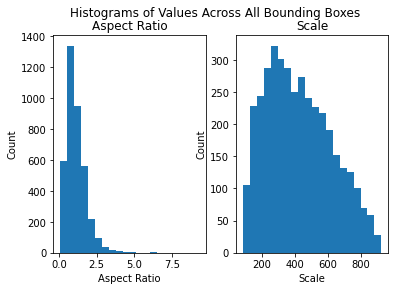

In [ ]:
# ANCHOR GENERATION VISUALIZATION
all_bboxes = np.concatenate([box for box in bounding_boxes])
w = all_bboxes[:,2]-all_bboxes[:,0]
h = all_bboxes[:,3]-all_bboxes[:,1]
scaled_w = w / 400 * 1066
scaled_h = h / 300 * 800
aspect_ratio = scaled_w / scaled_h
scale = np.sqrt(scaled_w*scaled_h)

plt.figure()

ax = plt.subplot(1,2,1)
ax.hist(aspect_ratio, bins=20)
ax.set_xlabel('Aspect Ratio')
ax.set_ylabel('Count')
ax.set_title('Aspect Ratio')
ax = plt.subplot(1,2,2)
ax.hist(scale, bins=20)
ax.set_xlabel('Scale')
ax.set_ylabel('Count')
ax.set_title('Scale')
plt.suptitle('Histograms of Values Across All Bounding Boxes')
plt.show()

Based on the histograms, it seems that the median aspect ratio across all bounding boxes is approximately 1, and the median of the scale across all bounding boxes is approximately 400. Thus, we will choose these values for our anchor boxes. This means that for each anchor box, $\frac{w}{h} = 1$, which means that $w=h$. We also have $\sqrt{wh} = \sqrt{w^2} = w = h = 400$. Thus each anchor box will be a square box with side length 400.

In [ ]:
from torch import nn

class RPNHead(pl.LightningModule):

    def __init__(self,  anchors_param=dict(ratio=0.8,scale= 256, grid_size=(50, 68), stride=16)):
      # Initialize the backbone, intermediate layer clasifier and regressor heads of the RPN
      super(RPNHead,self).__init__()

      self.maxpool = nn.MaxPool2d(2, stride=2)
      self.relu = nn.ReLU()
      self.sigmoid = nn.Sigmoid()

      self.backbone_convs = nn.ModuleList()  
      self.backbone_convs.append(nn.Conv2d(3,16, kernel_size=5,padding='same'))
      self.backbone_convs.append(nn.Conv2d(16,32, kernel_size=5,padding='same'))
      self.backbone_convs.append(nn.Conv2d(32,64, kernel_size=5,padding='same'))
      self.backbone_convs.append(nn.Conv2d(64,128, kernel_size=5,padding='same'))
      self.backbone_convs.append(nn.Conv2d(128,256, kernel_size=5,padding='same'))
      self.backbone_batchnorm = nn.ModuleList()
      self.backbone_batchnorm.append(nn.BatchNorm2d(16))
      self.backbone_batchnorm.append(nn.BatchNorm2d(32))
      self.backbone_batchnorm.append(nn.BatchNorm2d(64))
      self.backbone_batchnorm.append(nn.BatchNorm2d(128))
      self.backbone_batchnorm.append(nn.BatchNorm2d(256))

      self.intermediate_convs = nn.Conv2d(256, 256, kernel_size=3, padding='same')

      self.intermediate_bn = nn.BatchNorm2d(256)

      self.proposal_classifier = nn.Conv2d(256, 1, kernel_size=1, padding='same')

      self.proposal_regressor = nn.Conv2d(256, 4, kernel_size=1, padding='same')

      self.clf_head = nn.Conv2d(256, 1, kernel_size=1, padding='same')
      self.regr_head = nn.Conv2d(256, 4, kernel_size=1, padding='same')

      #  find anchors
      self.anchors_param=anchors_param
      self.anchors=self.create_anchors(self.anchors_param['ratio'],self.anchors_param['scale'],self.anchors_param['grid_size'],self.anchors_param['stride'])
      self.ground_dict={}

      self.bce_loss = nn.BCELoss()
      self.l1_loss = nn.SmoothL1Loss()

      self.train_losses = []
      self.val_losses = []
    
    def training_step(self, batch, batch_idx):
      images, labels, _, bounding_boxes, indexes = batch
      logits, bbox_regs = self.forward(images)
      ground_clas, ground_coord = self.create_batch_truth(bounding_boxes, indexes, (800, 1088))
      loss, loss_c, loss_r = self.compute_loss(logits, bbox_regs, ground_clas, ground_coord)
      self.log("train_loss", loss, prog_bar=True)
      self.log("train_class_loss", loss_c, prog_bar=True)
      self.log("train_regr_loss", loss_r, prog_bar=True)

      return {"loss": loss, "loss_c": loss_c, "loss_r": loss_r}
    
    def validation_step(self, batch, batch_idx):
      images, labels, _, bounding_boxes, indexes = batch
      logits, bbox_regs = self.forward(images)
      ground_clas, ground_coord = self.create_batch_truth(bounding_boxes, indexes, (800, 1088), val=True)
      loss, loss_c, loss_r = self.compute_loss(logits, bbox_regs, ground_clas, ground_coord)
      self.log("val_loss", loss, prog_bar=True)
      self.log("val_class_loss", loss_c, prog_bar=True)
      self.log("val_regr_loss", loss_r, prog_bar=True)

      return {"loss": loss, "loss_c": loss_c, "loss_r": loss_r}
    
    def training_epoch_end(self, outputs):
      loss = torch.tensor([output["loss"] for output in outputs]).mean().item()
      loss_c = torch.tensor([output["loss_c"] for output in outputs]).mean().item()
      loss_r = torch.tensor([output["loss_r"] for output in outputs]).mean().item()
      self.train_losses.append((loss, loss_c, loss_r))
    
    def validation_epoch_end(self, outputs):
      loss = torch.tensor([output["loss"] for output in outputs]).mean().item()
      loss_c = torch.tensor([output["loss_c"] for output in outputs]).mean().item()
      loss_r = torch.tensor([output["loss_r"] for output in outputs]).mean().item()
      self.val_losses.append((loss, loss_c, loss_r))

    # Forward  the input through the backbone the intermediate layer and the RPN heads
    # Input:
    #       X: (bz,3,image_size[0],image_size[1])}
    # Ouput:
    #       logits: (bz,1,grid_size[0],grid_size[1])}
    #       bbox_regs: (bz,4, grid_size[0],grid_size[1])}
    def forward(self, X):
      out = X.float()
        
      for i in range(5):
        out =  self.backbone_convs[i](out)
        out = self.backbone_batchnorm[i](out)
        out = self.relu(out)
        if (i<4):
          out = self.maxpool(out)

      out = self.relu(self.intermediate_bn(self.intermediate_convs(out)))

      logits = self.sigmoid(self.proposal_classifier(out))
      bbox_regs = self.proposal_regressor(out)

      assert logits.shape[1:4]==(1,self.anchors_param['grid_size'][0],self.anchors_param['grid_size'][1])
      assert bbox_regs.shape[1:4]==(4,self.anchors_param['grid_size'][0],self.anchors_param['grid_size'][1])

      return logits, bbox_regs

    # This function creates the anchor boxes
    # Output:
    #       anchors: (grid_size[0],grid_size[1],4)
    #  each box contains: (center_x, center_y, w, h)
    def create_anchors(self, aspect_ratio, scale, grid_sizes, stride):
      h_a = np.sqrt(np.square(scale) / aspect_ratio)
      w_a = h_a * aspect_ratio
      grid_lower_bounds_x = np.arange(0, 1088, stride)
      grid_upper_bounds_x = grid_lower_bounds_x + stride
      grid_lower_bounds_y = np.arange(0, 800, stride)
      grid_upper_bounds_y = grid_lower_bounds_y + stride
      grid_center_x = (grid_lower_bounds_x+grid_upper_bounds_x) / 2
      grid_center_x = np.tile(np.expand_dims(grid_center_x, axis=0), (grid_sizes[0], 1))
      grid_center_y = (grid_lower_bounds_y + grid_upper_bounds_y) / 2
      grid_center_y = np.tile(np.expand_dims(grid_center_y, axis=1), (1, grid_sizes[1]))
      grid_w = np.ones(grid_sizes) * w_a
      grid_h = np.ones(grid_sizes) * h_a
      anchors = [grid_center_x, grid_center_y, grid_w, grid_h]
      anchors = np.concatenate([np.expand_dims(x, axis=2) for x in anchors], axis=2)

      assert anchors.shape == (grid_sizes[0] , grid_sizes[1],4)
      return anchors

    def get_anchors(self):
        return self.anchors

    # This function creates the ground truth for a batch of images by using
    # create_ground_truth internally
    # Input:
    #      bboxes_list: list:len(bz){(n_obj,4)}
    #      indexes:      list:len(bz)
    #      image_shape:  tuple:len(2)
    # Output:
    #      ground_clas: (bz,1,grid_size[0],grid_size[1])
    #      ground_coord: (bz,4,grid_size[0],grid_size[1])
    def create_batch_truth(self,bboxes_list,indexes,image_shape, val=False):
      ground_clas = []
      ground_coord = []
      for i in range(len(indexes)):
        ground_truth = self.create_ground_truth(bboxes_list[i], indexes[i], self.anchors_param['grid_size'], self.anchors, image_shape, val=val)
        ground_clas.append(ground_truth[0])
        ground_coord.append(ground_truth[1])
      ground_clas = torch.cat([x.unsqueeze(0) for x in ground_clas], axis=0)
      ground_coord = torch.cat([x.unsqueeze(0) for x in ground_coord], axis=0)
      assert ground_clas.shape[1:4]==(1,self.anchors_param['grid_size'][0],self.anchors_param['grid_size'][1])
      assert ground_coord.shape[1:4]==(4,self.anchors_param['grid_size'][0],self.anchors_param['grid_size'][1])
      return ground_clas, ground_coord

    # This function creates the ground truth for one image
    # It also caches the ground truth for the image using its index
    # Input:
    #       bboxes:      (n_boxes,4)
    #       index:       scalar (the index of the image in the total dataset used for caching)
    #       grid_size:   tuple:len(2)
    #       anchors:     (grid_size[0],grid_size[1],4)
    # Output:
    #       ground_clas:  (1,grid_size[0],grid_size[1])
    #       ground_coord: (4,grid_size[0],grid_size[1])
    def create_ground_truth(self, bboxes, index, grid_size, anchors, image_size, val=False):
      key = str(index) + "v" if val else str(index)
      if key in self.ground_dict:
        groundt, ground_coord = self.ground_dict[key]
        return groundt, ground_coord

      flattened_anchors = anchors.reshape(-1, 4)
      anchor_xmin = flattened_anchors[:,0]-(flattened_anchors[:,2]/2)
      anchor_xmax = flattened_anchors[:,0]+(flattened_anchors[:,2]/2)
      anchor_ymin = flattened_anchors[:,1]-(flattened_anchors[:,3]/2)
      anchor_ymax = flattened_anchors[:,1]+(flattened_anchors[:,3]/2)
      valid_anchors1 = np.logical_and(anchor_xmin >= 0, anchor_xmax <= image_size[1])
      valid_anchors2 = np.logical_and(anchor_ymin >= 0, anchor_ymax <= image_size[0])
      valid_anchors = np.logical_and(valid_anchors1, valid_anchors2)

      # positive anchors are 1, negative anchors are 0, neither are -1
      ground_clas = np.ones((1, grid_size[0]*grid_size[1])) * -1
      ground_coord = np.zeros((4, grid_size[0]*grid_size[1]))

      cx = (bboxes[:,0]+bboxes[:,2])/2
      cy = (bboxes[:,1]+bboxes[:,3])/2
      w = bboxes[:,2]-bboxes[:,0]
      h = bboxes[:,3]-bboxes[:,1]
      bboxes_new = [cx, cy, w, h]
      bboxes_new = np.concatenate([np.expand_dims(x, axis=1) for x in bboxes_new], axis=1)
      neg_iou_matches = np.ones((grid_size[0]*grid_size[1]), dtype=bool)

      for bbox in bboxes_new:
        iou = IOU(bbox, flattened_anchors)

        pos_iou_matches = np.nonzero(np.logical_and(iou > 0.7, valid_anchors))[0]
        neg_iou = iou < 0.3
        neg_iou_matches = np.logical_and(neg_iou_matches, neg_iou)
        if len(pos_iou_matches) > 0:
          matches = flattened_anchors[pos_iou_matches,:]
          tx = (bbox[0]-matches[:,0])/matches[:,2]
          ty = (bbox[1]-matches[:,1])/matches[:,3]
          tw = np.log(bbox[2] / matches[:,2])
          th = np.log(bbox[3] / matches[:,3])
          ground_clas[0, pos_iou_matches] = 1
          ground_coord[0, pos_iou_matches] = tx
          ground_coord[1, pos_iou_matches] = ty
          ground_coord[2, pos_iou_matches] = tw
          ground_coord[3, pos_iou_matches] = th
        else:
          iou_max = np.copy(iou)
          iou_max[np.logical_not(valid_anchors)] = 0
          pos_iou_match = np.argmax(iou_max)
          neg_iou_matches[pos_iou_match] = False
          match = flattened_anchors[pos_iou_match,:]
          tx = (bbox[0]-match[0])/match[2]
          ty = (bbox[1]-match[1])/match[3]
          tw = np.log(bbox[2] / match[2])
          th = np.log(bbox[3] / match[3])
          ground_clas[0, pos_iou_match] = 1
          ground_coord[0, pos_iou_match] = tx
          ground_coord[1, pos_iou_match] = ty
          ground_coord[2, pos_iou_match] = tw
          ground_coord[3, pos_iou_match] = th
      
      ground_clas[0, neg_iou_matches] = 0
      ground_clas[0, np.logical_not(valid_anchors)]=-1

      ground_clas = torch.tensor(ground_clas.reshape(1, grid_size[0], grid_size[1]), device=device)
      ground_coord = torch.tensor(ground_coord.reshape(4, grid_size[0], grid_size[1]), device=device)
      self.ground_dict[key] = (ground_clas, ground_coord.float())

      assert ground_clas.shape==(1,grid_size[0],grid_size[1])
      assert ground_coord.shape==(4,grid_size[0],grid_size[1])

      return ground_clas, ground_coord.float()

    # Compute the loss of the classifier
    # Input:
    #      p_out:     (positives_on_mini_batch)  (output of the classifier for sampled anchors with positive gt labels)
    #      n_out:     (negatives_on_mini_batch) (output of the classifier for sampled anchors with negative gt labels
    def loss_class(self,p_out,n_out, p_true, n_true):
      input = torch.cat([p_out, n_out]).float()
      target = torch.cat([p_true, n_true]).float()
      loss = self.bce_loss(input, target)
      return loss

    # Compute the loss of the regressor
    # Input:
    #       pos_target_coord: (positive_on_mini_batch,4) (ground truth of the regressor for sampled anchors with positive gt labels)
    #       pos_out_r: (positive_on_mini_batch,4)        (output of the regressor for sampled anchors with positive gt labels)
    def loss_reg(self,pos_target_coord,pos_out_r):
      loss = 0
      for i in range(4):
        loss += self.l1_loss(pos_out_r[:,i], pos_target_coord[:,i])
      return loss

    # Compute the total loss
    # Input:
    #       clas_out: (bz,1,grid_size[0],grid_size[1])
    #       regr_out: (bz,4,grid_size[0],grid_size[1])
    #       targ_clas:(bz,1,grid_size[0],grid_size[1])
    #       targ_regr:(bz,4,grid_size[0],grid_size[1])
    #       l: lambda constant to weight between the two losses
    #       effective_batch: the number of anchors in the effective batch (M in the handout)
    def compute_loss(self,clas_out,regr_out,targ_clas,targ_regr, l=1, effective_batch=50):
      num_pos_max = int(effective_batch/2)
      num_pos = min(torch.sum(targ_clas == 1).item(), num_pos_max)
      num_neg = effective_batch - num_pos
      flattened_targ_clas = targ_clas.reshape(-1)
      flattened_targ_regr = targ_regr.permute(0, 2, 3, 1).reshape(-1, 4)
      flattened_clas_out = clas_out.reshape(-1)
      flattened_regr_out = regr_out.permute(0, 2, 3, 1).reshape(-1, 4)
      pos_idx = torch.nonzero(flattened_targ_clas==1)[:,0]
      pos_idx = pos_idx[np.random.choice(np.arange(len(pos_idx)), size=num_pos, replace=False)]
      neg_idx = torch.nonzero(flattened_targ_clas==0)[:,0]
      neg_idx = neg_idx[np.random.choice(np.arange(len(neg_idx)), size=num_neg, replace=False)]
      p_out = flattened_clas_out[pos_idx]
      n_out = flattened_clas_out[neg_idx]
      p_true = flattened_targ_clas[pos_idx]
      n_true = flattened_targ_clas[neg_idx]
      loss_c = self.loss_class(p_out, n_out, p_true, n_true)
      pos_target_coord = flattened_targ_regr[pos_idx,:]
      pos_out_r = flattened_regr_out[pos_idx,:]
      loss_r = self.loss_reg(pos_target_coord, pos_out_r)
      loss = loss_c + l*loss_r
      return loss, loss_c, loss_r

    # Post process for the outputs for a batch of images
    # Input:
    #       out_c:  (bz,1,grid_size[0],grid_size[1])}
    #       out_r:  (bz,4,grid_size[0],grid_size[1])}
    #       IOU_thresh: scalar that is the IOU threshold for the NMS
    #       keep_num_preNMS: number of masks we will keep from each image before the NMS
    #       keep_num_postNMS: number of masks we will keep from each image after the NMS
    # Output:
    #       nms_clas_list: list:len(bz){(Post_NMS_boxes)} (the score of the boxes that the NMS kept)
    #       nms_prebox_list: list:len(bz){(Post_NMS_boxes,4)} (the coordinates of the boxes that the NMS kept)
    def postprocess(self,out_c,out_r, IOU_thresh=0.5, keep_num_preNMS=50, keep_num_postNMS=10):
      out_c = out_c.detach().cpu().numpy()
      out_r = out_r.detach().cpu().numpy()
      bz = out_c.shape[0]
      flatten_regr, flatten_clas, flatten_anchors = output_flattening(out_r, out_c, self.anchors)
      nms_clas_list = []
      nms_prebox_list = []

      for b in range(bz):
        nms_clas, nms_prebox = self.postprocessImg(flatten_clas[b], flatten_regr[b], flatten_anchors, IOU_thresh, keep_num_preNMS, keep_num_postNMS)
        nms_clas_list.append(nms_clas)
        nms_prebox_list.append(nms_prebox)
           
      return nms_clas_list, nms_prebox_list

    # Post process the output for one image
    # Input:
    #      mat_clas: (grid_size[0]*grid_size[1], )}  (scores of the output boxes)
    #      mat_coord: (grid_size[0]*grid_size[1], 4)} (encoded coordinates of the output boxes)
    #      mat_anchors: (grid_size[0]*grid_size[1], 4)
    # Output:
    #       nms_clas: (Post_NMS_boxes)
    #       nms_prebox: (Post_NMS_boxes,4) (decoded coordinates of the boxes that the NMS kept)
    def postprocessImg(self,mat_clas,mat_coord, mat_anchors, IOU_thresh,keep_num_preNMS, keep_num_postNMS):
      scores = mat_clas.reshape(-1)
      boxes = output_decoding(mat_coord, flatten_anchors)

      boxes[boxes[:,0] < 0, 0] = 0
      boxes[boxes[:,1] < 0, 1] = 0
      boxes[boxes[:,2] > 1088, 2] = 1088
      boxes[boxes[:,3] > 800, 3] = 800
      K = min(keep_num_preNMS, len(scores))
      sorted_idx = np.argsort(scores)[::-1]
      top_k_idx = sorted_idx[:K]
      scores = scores[top_k_idx]
      boxes = boxes[top_k_idx,:]

      nms_clas, nms_prebox = self.NMS(scores, boxes, IOU_thresh)

      N = min(keep_num_postNMS, len(nms_clas))
      nms_clas = nms_clas[:N]
      nms_prebox = nms_prebox[:N,:]
      return nms_clas, nms_prebox

    # Input:
    #       clas: (top_k_boxes) (scores of the top k boxes)
    #       prebox: (top_k_boxes,4) (coordinate of the top k boxes)
    # Output:
    #       nms_clas: (Post_NMS_boxes)
    #       nms_prebox: (Post_NMS_boxes,4)
    def NMS(self,clas,prebox, thresh):
      sorted_prediction = np.concatenate([np.expand_dims(clas, axis=1), prebox], axis=1)
      postprocessed_prediction = []
      remaining_prediction = sorted_prediction
      while remaining_prediction.shape[0] > 0:
        current = remaining_prediction[0,:]
        remaining_prediction = remaining_prediction[1:,:]
        postprocessed_prediction.append(np.expand_dims(current, axis=0))
        if remaining_prediction.shape[0] == 0:
          break
        intersect_x_min = np.maximum(current[1], remaining_prediction[:,1])
        intersect_y_min = np.maximum(current[2], remaining_prediction[:,2])
        intersect_x_max = np.minimum(current[3], remaining_prediction[:,3])
        intersect_y_max = np.minimum(current[4], remaining_prediction[:,4])
        intersect = (intersect_x_max - intersect_x_min) * (intersect_y_max - intersect_y_min)
        invalid_idx = np.logical_or(intersect_x_max < intersect_x_min, intersect_y_max < intersect_y_min)
        area = (remaining_prediction[:,4]-remaining_prediction[:,2]) * (remaining_prediction[:,3]-remaining_prediction[:,1])
        current_area = (current[4]-current[2]) * (current[3]-current[1])
        union = current_area + area - intersect
        iou = intersect / union
        iou[invalid_idx] = 0
        iou[union==0] = 0
        idx = np.logical_not(iou > thresh)
        remaining_prediction = remaining_prediction[idx, :]
    
      if len(postprocessed_prediction) == 0:
        return np.zeros((0, 5))
  
      output = np.concatenate(postprocessed_prediction, axis=0)

      return output[:,0], output[:,1:]
    
    def configure_optimizers(self):
      opt = torch.optim.Adam(self.parameters(), lr=0.001, weight_decay=5e-4)
      sched = {"scheduler": torch.optim.lr_scheduler.MultiStepLR(opt, milestones=[20, 30], gamma=0.1)}
      return {"optimizer": opt, "lr_scheduler": sched}

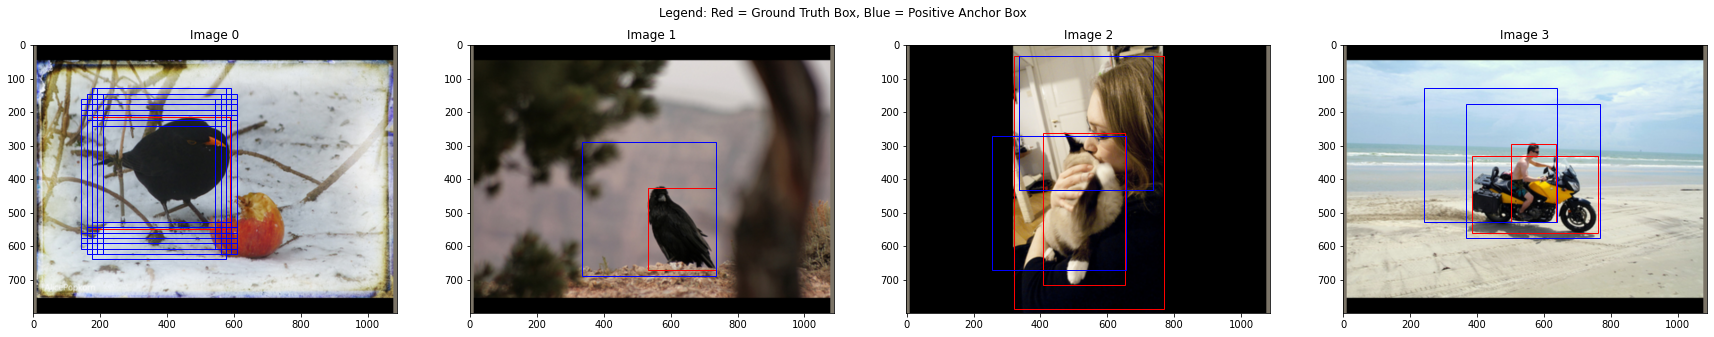

In [ ]:
# TARGET VISUALIZATION CELL
# DATASET PREPROCESSING VISUALIZATION CELL

logger = logging.getLogger()
old_level = logger.level
logger.setLevel(100)
rpn_net = RPNHead(anchors_param=dict(ratio=1,scale=400, grid_size=(50, 68), stride=16))

plt.figure(figsize=(30, 5))
for batch in train_loader:
  img_batch, _, _, bbox_batch, indexes = batch
  ground_class, ground_coord = rpn_net.create_batch_truth(bbox_batch, indexes, (800, 1088))
  out_c = ground_class.detach().cpu().numpy()
  out_r = ground_coord.detach().cpu().numpy()
  flatten_r, flatten_c, flatten_anchors = output_flattening(out_r, out_c, rpn_net.anchors)
  for b in range(img_batch.shape[0]):

    ax=plt.subplot(1,4, b+1)
    img_to_display = transforms.functional.normalize(img_batch[b],[-0.485/0.229, -0.456/0.224, -0.406/0.225], [1/0.229, 1/0.224, 1/0.225], inplace=False).permute(1,2,0)
    ax.imshow(img_to_display)
    ax.set_title("Image " + str(b))
    gt_boxes = output_decoding(flatten_r[b], flatten_anchors)
    gt_boxes = gt_boxes[flatten_c[b,:]==1, :]
    anchor_boxes = flatten_anchors[flatten_c[b,:]==1,:]
    for j in range(gt_boxes.shape[0]):
      w = gt_boxes[j, 2]-gt_boxes[j,0]
      h = gt_boxes[j,3]-gt_boxes[j,1]
      rect = Rectangle((gt_boxes[j,0], gt_boxes[j,1]), w, h, edgecolor='r', facecolor=None, fill=False)
      ax.add_patch(rect)
    for j in range(anchor_boxes.shape[0]):
      w = anchor_boxes[j,2]
      h = anchor_boxes[j,3]
      rect = Rectangle((anchor_boxes[j,0]-(w/2), anchor_boxes[j,1]-(h/2)), w, h, edgecolor='b', facecolor=None, fill=False)
      ax.add_patch(rect)
  break

plt.suptitle('Legend: Red = Ground Truth Box, Blue = Positive Anchor Box')
plt.show()
logger.setLevel(old_level)

In [ ]:
# TRAINING

num_epochs = 36

train_loader = DataLoader(train_dataset, batch_size=8, collate_fn=collate_fn, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, collate_fn=collate_fn, shuffle=False)

model = RPNHead(anchors_param=dict(ratio=1,scale=400, grid_size=(50, 68), stride=16))
trainer = pl.Trainer(max_epochs=num_epochs, gpus=1, num_sanity_val_steps=0)
trainer.fit(model, train_loader, val_loader)
torch.save(model.state_dict(), 'rpn.pth')
np.save('train_losses.npy', model.train_losses)
np.save('val_losses.npy', model.val_losses)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                | Type         | Params
------------------------------------------------------
0  | maxpool             | MaxPool2d    | 0     
1  | relu                | ReLU         | 0     
2  | sigmoid             | Sigmoid      | 0     
3  | backbone_convs      | ModuleList   | 1.1 M 
4  | backbone_batchnorm  | ModuleList   | 992   
5  | intermediate_convs  | Conv2d       | 590 K 
6  | intermediate_bn     | BatchNorm2d  | 512   
7  | proposal_classifier | Conv2d       | 257   
8  | proposal_regressor  | Conv2d       | 1.0 K 
9  | clf_head            | Conv2d       | 257   
10 | regr_head           | Conv2d       | 1.0 K 
11 | bce_loss            | BCELoss      | 0     
12 | l1_loss             | SmoothL1Loss | 0     
------------------------------------------------------
1.7 M     Trainable params
0         Non-trainable p

Training: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/data.py:57: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 8. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  "Trying to infer the `batch_size` from an ambiguous collection. The batch size we"
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/loops/optimization/closure.py:36: LightningDeprecationWarning: One of the returned values {'loss_c', 'loss_r'} has a `grad_fn`. We will detach it automatically but this behaviour will change in v

Validating: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/data.py:57: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 5. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  "Trying to infer the `batch_size` from an ambiguous collection. The batch size we"


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [ ]:
# LOAD FINAL MODEL WEIGHTS
model = RPNHead(anchors_param=dict(ratio=1,scale=400, grid_size=(50, 68), stride=16)).to(device)
model.eval().load_state_dict(torch.load('rpn.pth', map_location='cpu'))

<All keys matched successfully>

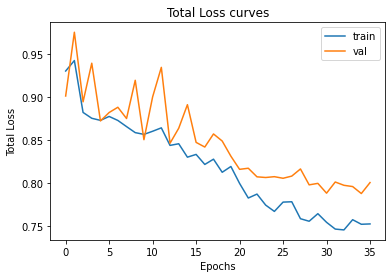

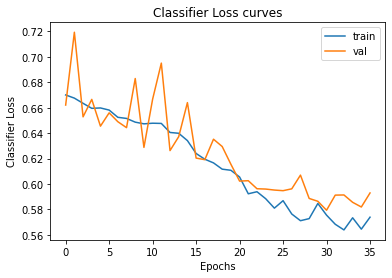

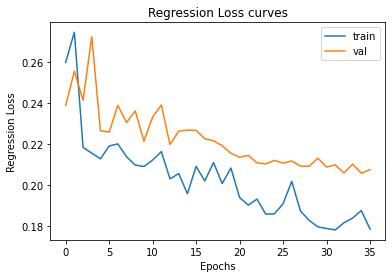

In [ ]:
# RUN THIS CELL TO VISUALIZE LOSSES OVER TRAINING
import matplotlib.pyplot as plt

train_losses = np.load('train_losses.npy')
val_losses = np.load('val_losses.npy')

plt.figure()
epochs = np.arange(36)
plt.plot(epochs, [l[0] for l in train_losses])
plt.plot(epochs, [l[0] for l in val_losses])
plt.xlabel('Epochs')
plt.ylabel('Total Loss')
plt.title('Total Loss curves')

plt.legend(['train', 'val']) 

plt.figure()
plt.plot(epochs, [l[1] for l in train_losses])
plt.plot(epochs, [l[1] for l in val_losses])
plt.xlabel('Epochs')
plt.ylabel('Classifier Loss')
plt.title('Classifier Loss curves')

plt.legend(['train', 'val']) 

plt.figure()
plt.plot(epochs, [l[2] for l in train_losses])
plt.plot(epochs, [l[2] for l in val_losses])
plt.xlabel('Epochs')
plt.ylabel('Regression Loss')
plt.title('Regression Loss curves')

plt.legend(['train', 'val']) 
plt.show()

In [ ]:
# REPORT OF POINTWISE ACCURACY
val_loader = DataLoader(val_dataset, batch_size=1, collate_fn=collate_fn)
num_total = 0
num_correct = 0
for batch in val_loader:
  img_batch, label_batch, _, bbox_batch, idx_batch = batch
  logits, bbox_regs = model(img_batch.to(device))
  ground_clas, _ = model.create_batch_truth(bbox_batch, idx_batch, (800, 1088))
  num_pos = torch.sum(ground_clas == 1).item()
  num_neg = torch.sum(ground_clas == 0).item()
  num_total = num_total + num_pos + num_neg
  num_pos_correct = torch.sum(torch.logical_and(ground_clas == 1, logits >= 0.5)).item()
  num_neg_correct = torch.sum(torch.logical_and(ground_clas == 0, logits < 0.5)).item()
  num_correct = num_correct + num_pos_correct + num_neg_correct

acc = num_correct / num_total
print("Final test pointwise accuracy: " + str(acc))

Final test pointwise accuracy: 0.7745686973245093


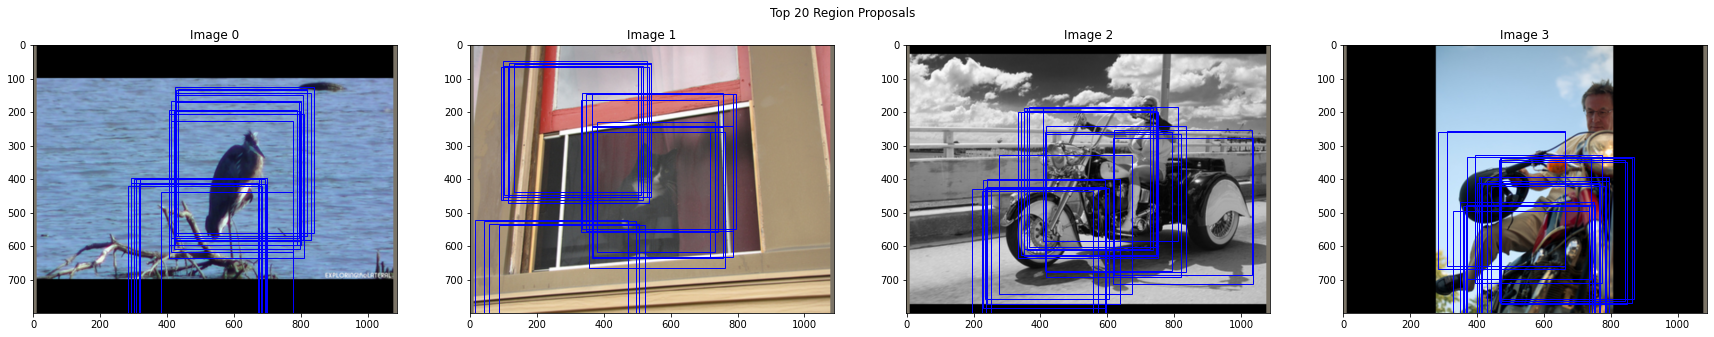

In [ ]:
# PLOT OF TOP 20 PROPOSALS FOR SELECTED IMAGES
logger = logging.getLogger()
old_level = logger.level
logger.setLevel(100)
val_loader = DataLoader(val_dataset, batch_size=4, collate_fn=collate_fn)
plt.figure(figsize=(30, 5))

for batch in val_loader:
  img_batch, _, _, _, _ = batch
  out_c, out_r = model(img_batch.to(device))
  out_c = out_c.detach().cpu().numpy()
  out_r = out_r.detach().cpu().numpy()
  bz = out_c.shape[0]
  flatten_regr, flatten_clas, flatten_anchors = output_flattening(out_r, out_c, model.anchors)

  for b in range(bz):
    ax=plt.subplot(1,4, b+1)
    img_to_display = transforms.functional.normalize(img_batch[b],[-0.485/0.229, -0.456/0.224, -0.406/0.225], [1/0.229, 1/0.224, 1/0.225], inplace=False).permute(1,2,0)
    ax.imshow(img_to_display)
    ax.set_title("Image " + str(b))
    scores = flatten_clas[b].reshape(-1)
    boxes = flatten_regr[b]
    boxes = output_decoding(boxes, flatten_anchors)
    # clip boundaries
    boxes[boxes[:,0] < 0, 0] = 0
    boxes[boxes[:,1] < 0, 1] = 0
    boxes[boxes[:,2] > 1088, 2] = 1088
    boxes[boxes[:,3] > 800, 3] = 800
    # sort and get top k boxes
    K = min(20, len(scores))
    sorted_idx = np.argsort(scores)[::-1]
    top_k_idx = sorted_idx[:K]
    scores = scores[top_k_idx]
    boxes = boxes[top_k_idx,:]
    for j in range(boxes.shape[0]):
      w = boxes[j,2]-boxes[j,0]
      h = boxes[j,3]-boxes[j,1]
      rect = Rectangle((boxes[j,0], boxes[j,1]), w, h, edgecolor='b', facecolor=None, fill=False)
      ax.add_patch(rect)

  break

plt.suptitle('Top 20 Region Proposals')
plt.show()
logger.setLevel(old_level)

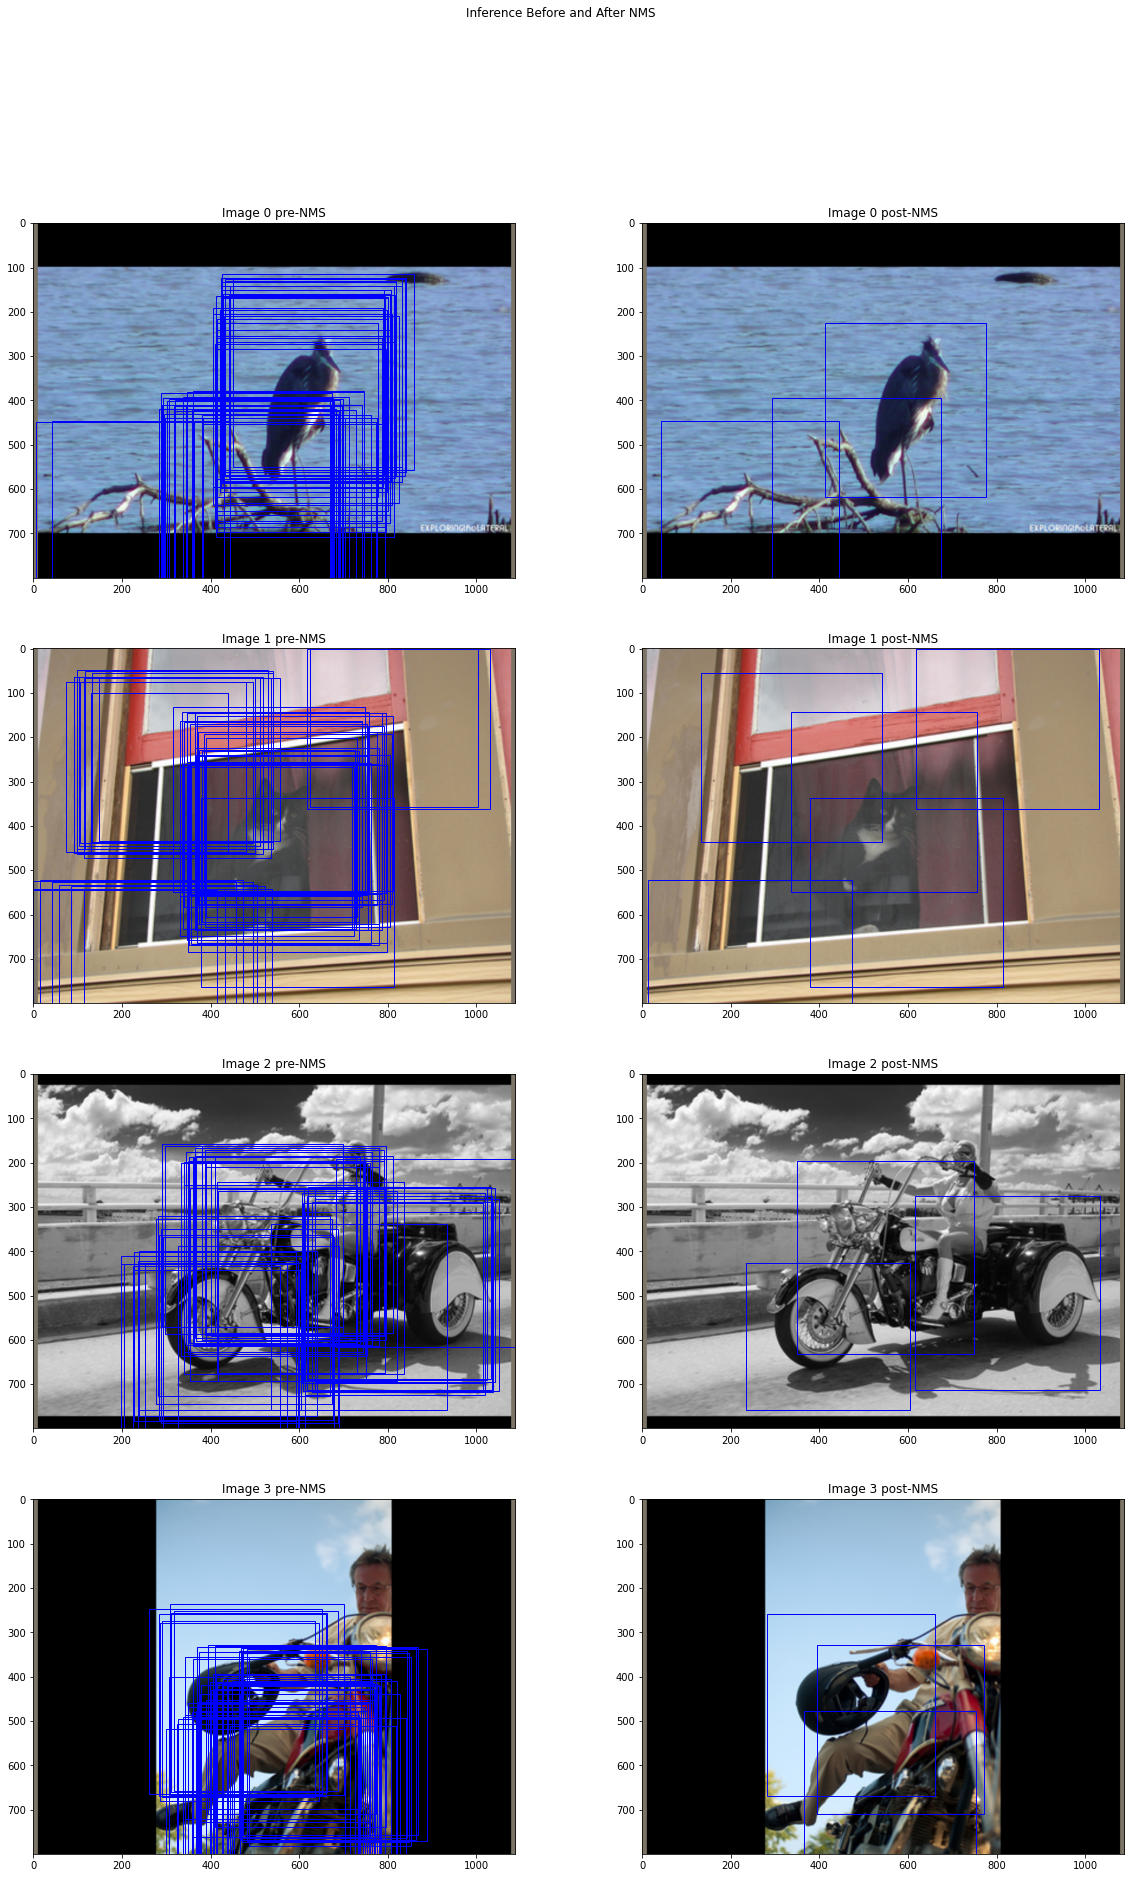

In [ ]:
# VISUALIZATION OF POSTPROCESSING/NMS
logger = logging.getLogger()
old_level = logger.level
logger.setLevel(100)
plt.figure(figsize=(20, 30))

for batch in val_loader:
  img_batch, _, _, _, _ = batch
  out_c, out_r = model(img_batch.to(device))
  _, nms_box_list = model.postprocess(out_c,out_r)
  out_c = out_c.detach().cpu().numpy()
  out_r = out_r.detach().cpu().numpy()
  bz = out_c.shape[0]
  flatten_regr, flatten_clas, flatten_anchors = output_flattening(out_r, out_c, model.anchors)

  for b in range(bz):
    ax=plt.subplot(4,2, b*2+1)
    img_to_display = transforms.functional.normalize(img_batch[b],[-0.485/0.229, -0.456/0.224, -0.406/0.225], [1/0.229, 1/0.224, 1/0.225], inplace=False).permute(1,2,0)
    ax.imshow(img_to_display)
    ax.set_title("Image " + str(b) + " pre-NMS")
    scores = flatten_clas[b].reshape(-1)
    boxes = flatten_regr[b]
    boxes = output_decoding(boxes, flatten_anchors)
    # clip boundaries
    boxes[boxes[:,0] < 0, 0] = 0
    boxes[boxes[:,1] < 0, 1] = 0
    boxes[boxes[:,2] > 1088, 2] = 1088
    boxes[boxes[:,3] > 800, 3] = 800
    # sort and get top k boxes
    K = min(50, len(scores))
    sorted_idx = np.argsort(scores)[::-1]
    top_k_idx = sorted_idx[:K]
    scores = scores[top_k_idx]
    boxes = boxes[top_k_idx,:]
    for j in range(boxes.shape[0]):
      w = boxes[j,2]-boxes[j,0]
      h = boxes[j,3]-boxes[j,1]
      rect = Rectangle((boxes[j,0], boxes[j,1]), w, h, edgecolor='b', facecolor=None, fill=False)
      ax.add_patch(rect)
    nms_boxes = nms_box_list[b]
    ax=plt.subplot(4,2, b*2+2)
    ax.imshow(img_to_display)
    ax.set_title("Image " + str(b) + " post-NMS")
    for j in range(nms_boxes.shape[0]):
      w = nms_boxes[j,2]-nms_boxes[j,0]
      h = nms_boxes[j,3]-nms_boxes[j,1]
      rect = Rectangle((nms_boxes[j,0], nms_boxes[j,1]), w, h, edgecolor='b', facecolor=None, fill=False)
      ax.add_patch(rect)

  break

plt.suptitle('Inference Before and After NMS')
plt.show()
logger.setLevel(old_level)